In [25]:
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt

class costing: 
    
    #Function to Clean and Normalize the data
    def data_clean(self,data):
        X = data.loc[:,data.columns != 'label']       
        y = data['label']
        X = np.array(X)
        X = (X - X.min())/(X.max()-X.min())
        X,y = np.array(X),np.array(y)
        X = np.concatenate(([np.ones((X.shape[0],1)),X]), axis = 1)
        return X, y
    
    #Sigmoid Function
    def sigmoid(self,z):
        z = np.array(z)
        g = 1/(1+np.exp(-z))
        return g
    
    # Regularized cost function - works for weights of every class separately
    def costFunctionReg(self,w,X,y,lambda_):        
        J = 0       
        m = len(X)
        reg = 0
        h = self.sigmoid(X@w)
        for k in range(1,len(w)):
            reg += w[k]**2
        reg = reg*lambda_/2/m
        J = J- np.dot(y,np.log(h)+10**(-20))-np.dot((np.ones(m)-y),np.log((np.ones(m)-h+10**(-20)))) 
        J = J/m + reg
        grad = np.transpose(X)@(h-y)
        grad[1:] += lambda_*w[1:]
        grad = grad/m
        return J, grad
    
    #Predicts the most probable label for a feature vector
    def predictOneVsAll(self,all_w,X,num_labels):
        m = X.shape[0]
        num_labels = all_w.shape[0]
        p = np.zeros(m)
        t = X@np.transpose(all_w)
        for k in range(len(t)):
            f = np.argmax(t[k])
            p[k] = f    
        return p
    
    #Class variables used for plotting and TestingAccu
    all_w = np.array([np.zeros(785) for i in range(10)])
    num_iters = 0
    J_hist = []
    
    #Function to assist callback
    def call(self,x,X,y,lambda_):
        j,g = self.costFunctionReg(x,X,y,lambda_)
        self.J_hist.append(j)
        self.num_iters += 1
        
    # Optimization
    def minCostFun(self, train_data): #'train_data' is a pandas dataframe
        X,y = self.data_clean(train_data)
        lambda_ = 0.1         # Regularization parameter
        iters = 4000
        num_labels = 10
        m, n = X.shape
        plt.figure() 
        for c in np.arange(num_labels):
            initial_w = np.zeros(n)
            c1 = (y == c)
            if c1.dtype == bool:
                c1 = c1.astype(int)
            options = {'maxiter':4000}
            res = optimize.minimize(self.costFunctionReg,
                                    initial_w,
                                    (X,c1,lambda_),
                                    jac = True,
                                    method = 'CG',
                                    options = options,
                                    callback = self.call(initial_w,X,c1,lambda_))        
            self.all_w[c] = np.round(res.x,3)
            iterations = np.linspace(1,self.num_iters,self.num_iters)
            plt.plot(iterations,self.J_hist)
        acrcy = 0
        p = self.predictOneVsAll(self.all_w,X,num_labels)
        acrcy = round(np.mean((p==y)*100),3)        
        return self.all_w, acrcy
      
    # Calculate testing accuracy
    def TestingAccu(self, test_data):
        X,y = self.data_clean(test_data)
        p = self.predictOneVsAll(self.all_w,X,10)
        acrcy_test = round((np.mean(p==y)*100),3)        
        return acrcy_test

In [26]:
#Testing Syntax
num_labels = 10
lambda_ = 0.1
data = pd.read_csv('fashion-mnist_train.csv')
data1 = pd.read_csv('fashion-mnist_test.csv')
a = costing()
X,y = a.data_clean(data)

In [34]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


86.667 93.23


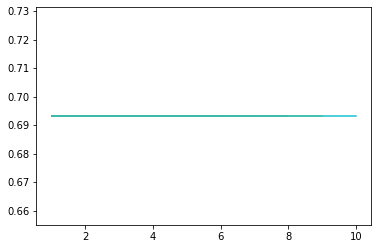

In [24]:
all_w,acrcy = a.minCostFun(data)
pred = a.predictOneVsAll(all_w,X,num_labels)
acrcy_test = a.TestingAccu(data1)
print(acrcy_test,acrcy)

In [16]:
#Function to display images
from matplotlib import pyplot
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    X1 = X.copy()
    X1 = np.delete(X1,0,1)
    if X1.ndim == 2:
        m, n = X1.shape #n is the no. of pixels here
    elif X1.ndim == 1:
        n = X1.size
        m = 1
        X1 = X1[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m/display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize = figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X1[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')
#This Function prints the labels of all the images which re being displayed        
def namer(l):
    res = []
    for i in l:
        res.append(d[i])
    return res    

d = {0:"T-Shirt/Top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandals",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle Boots"}        

['T-Shirt/Top', 'Trouser', 'Pullover', 'Pullover', 'Dress', 'Pullover', 'Bag', 'Shirt', 'Sandals', 'T-Shirt/Top', 'Dress', 'Coat', 'Coat', 'Shirt', 'Bag', 'Sandals', 'Shirt', 'Dress', 'Shirt', 'Coat', 'Coat', 'Coat', 'Pullover', 'Trouser', 'Sandals', 'Sneaker', 'Bag', 'Coat', 'Coat', 'Trouser']


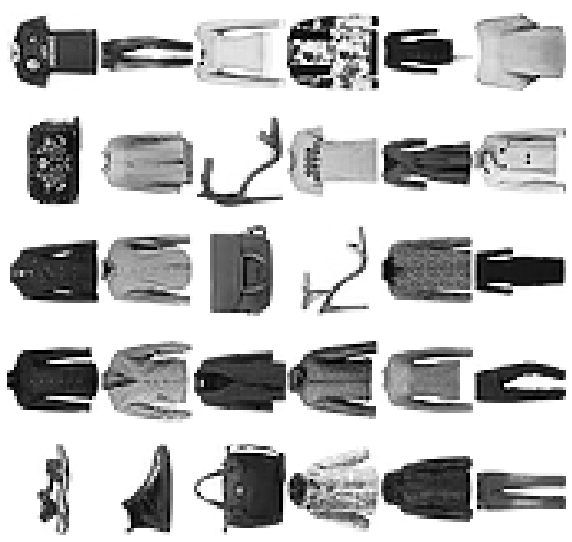

In [35]:
#Displaying some data and writing their PREDICTED names to check how the ML model is working
rand_indices = np.arange(0,30)
X1,y1 = a.data_clean(data1)
sel = X[rand_indices, :]
pred1 = a.predictOneVsAll(all_w,X1,num_labels)
print(namer(y[0:30]))
displayData(sel)